## 7. 순차적인 데이터를 처리하는 RNN

### 7.2 영화 리뷰 감정 분석
1: 부정적, 2: 긍정적

#### 7.2.1 자연어 전처리

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

In [18]:
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 5
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [19]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [20]:
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

In [21]:
TEXT.build_vocab(trainset, min_freq=5) # min_freq는 학습 데이터에서 최소 5번 이상 등장한 단어만을 사전에 담겠다.
LABEL.build_vocab(trainset)

In [22]:
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
(trainset, valset, testset), batch_size=BATCH_SIZE,
shuffle=True, repeat=False)

In [23]:
vocab_size = len(TEXT.vocab)
n_classes = 2

In [24]:
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
     % (len(trainset), len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


#### 7.2.2 RNN 모델 구현

In [25]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                         num_layers=self.n_layers,
                         batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)
    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)
        return logit
        
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [26]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)
        optimizer.zero_grad()
        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [27]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [28]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model


In [29]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)
    
    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.70 | 검증 정확도:50.40
[이폭: 2] 검증 오차: 0.70 | 검증 정확도:50.34
[이폭: 3] 검증 오차: 0.69 | 검증 정확도:51.60
[이폭: 4] 검증 오차: 0.69 | 검증 정확도:52.28
[이폭: 5] 검증 오차: 0.70 | 검증 정확도:50.60


In [ ]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

### 7.3 Seq2Seq 기계 번역

#### 7.3.4 Seq2Seq 모델 구현하기

In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256 # 총 아스키 코드 개수
x_ = list(map(ord, "hello")) # 아스키 코드로 변환
y_ = list(map(ord, "hola")) # 아스키 코드로 변환
x  = torch.LongTensor(x_)
y  = torch.LongTensor(y_)

In [3]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)
    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            # 디코더의 출력값으로 다음 글자 예측하기
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            # 티처 포싱을 이용한 디코더 입력 갱신
            decoder_input = torch.LongTensor([targets[i]])
            
        outputs = torch.stack(outputs).squeeze()
        return outputs
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [4]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)


 반복:0 오차: 0.5879571437835693
['h', 'o', 'l', 'a']

 반복:100 오차: 0.28112679719924927
['h', 'o', 'l', 'a']

 반복:200 오차: 0.17066136002540588
['h', 'o', 'l', 'a']

 반복:300 오차: 0.11920401453971863
['h', 'o', 'l', 'a']

 반복:400 오차: 0.08979062736034393
['h', 'o', 'l', 'a']

 반복:500 오차: 0.07083845138549805
['h', 'o', 'l', 'a']

 반복:600 오차: 0.05767454952001572
['h', 'o', 'l', 'a']

 반복:700 오차: 0.04804842174053192
['h', 'o', 'l', 'a']

 반복:800 오차: 0.040740158408880234
['h', 'o', 'l', 'a']

 반복:900 오차: 0.035029008984565735
['h', 'o', 'l', 'a']


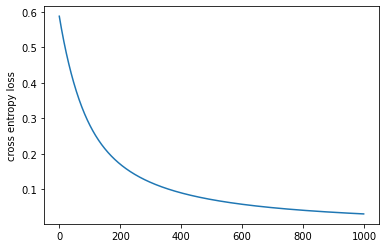

In [6]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])
    
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()